## Gender and Age Prediction using Inception V3 Model

We initially tried coding using inception V3 but due to low accuracy we modified our code and used CNN for the prediction. 
Below is our original Inception V3 model for Age and Gender prediction with accuracy for Age model 50.71% and gender 17.29% model.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
import imageio

In [2]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [3]:
def imshow(img):
    plt.imshow(img, interpolation='bicubic')
    plt.xticks([]), plt.yticks([]) 
    plt.show()

In [4]:
currentDirectory = os.getcwd()
dataset_name = os.path.join(currentDirectory, 'UTKFace/') 
onlyfiles = os.listdir(dataset_name)

In [6]:
len(onlyfiles)

23708

In [9]:
x_data =[]
for file in onlyfiles:
    face = cv2.imread(dataset_name+file)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face =cv2.resize(face, (200,200) )
    x_data.append(face)
x_data=np.array(x_data)
x_data.shape

x = np.squeeze(x_data)

# normalize data
x = x.astype('float32')
x /= 255
x.shape

(23708, 200, 200, 3)

## Gender Modelling

In [10]:
shuffle(onlyfiles)
gender = [i.split('_')[1] for i in onlyfiles]

In [11]:
gender_classes = []
for i in gender:
    i = int(i)
    gender_classes.append(i)

In [14]:
gender_classes[:10]

[1, 1, 0, 0, 1, 1, 0, 0, 1, 0]

In [15]:
gender_categorical_labels = to_categorical(gender_classes, num_classes=2)

In [16]:
gender_categorical_labels[:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [17]:
(x_train_g, y_train_g), (x_test_g, y_test_g) = (x[:15008],gender_categorical_labels[:15008]) , (x[15008:] , gender_categorical_labels[15008:])
(x_valid_g , y_valid_g) = (x_test_g[:7000], y_test_g[:7000])
(x_test_g, y_test_g) = (x_test_g[7000:], y_test_g[7000:])

In [18]:
len(x_train_g)


15008

In [19]:
len(x_train_g)+len(x_test_g) + len(x_valid_g) == len(x)

True

## Age Modelling

In [20]:
age = [i.split('_')[0] for i in onlyfiles]

In [21]:
age_classes = []
for i in age:
    i = int(i)
    if i <= 14:
        age_classes.append(0)
    if (i>14) and (i<=25):
        age_classes.append(1)
    if (i>25) and (i<40):
        age_classes.append(2)
    if (i>=40) and (i<60):
        age_classes.append(3)
    if i>=60:
        age_classes.append(4)      

In [23]:
age_categorical_labels = to_categorical(age_classes, num_classes=5)
age_categorical_labels[:10]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [24]:
(x_train_a, y_train_a), (x_test_a, y_test_a) = (x[:15008],age_categorical_labels[:15008]) , (x[15008:] , age_categorical_labels[15008:])
(x_valid_a , y_valid_a) = (x_test_a[:7000], y_test_a[:7000])
(x_test_a, y_test_a) = (x_test_a[7000:], y_test_a[7000:])

In [25]:
len(x_train_a)+len(x_test_a) + len(x_valid_a) == len(x)

True

In [27]:
# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

In [28]:
# Gender
train_datagen.fit(x_train_g)

train_generator_gender = train_datagen.flow(
x_train_g, y_train_g,
batch_size=64,
)

In [29]:
# Age
train_datagen.fit(x_train_a)

train_generator_age = train_datagen.flow(
x_train_a, y_train_a,
batch_size=64,
)


In [30]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights= currentDirectory+"/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5",
                        include_top=False,
                        input_shape=(200, 200, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [37]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
gender_predictions = Dense(2, activation="softmax")(x)
age_predictions = Dense(5, activation="softmax")(x)

## Final model for Gender Prediction

In [38]:
# creating the final model for Gender Prediction
gender_model = Model(inputs=inc_model.input, outputs=gender_predictions)

# Lock initial layers to do not be trained
for layer in gender_model.layers[:52]:
    layer.trainable = False

# compile the model
gender_model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [42]:
#https://keras.io/models/sequential/ fit generator
checkpointer_g = ModelCheckpoint(filepath='INC_weights.best.gender.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
g_hist = gender_model.fit_generator(train_generator_gender, 
                            validation_data = (x_valid_g, y_valid_g),
                            steps_per_epoch= 15008/64,
                            epochs= 50,
                            callbacks=[checkpointer_g],
                            verbose=1)

## Final model for Age Prediction

In [41]:
# creating the final model for Gender Prediction
age_model = Model(inputs=inc_model.input, outputs=age_predictions)

# Lock initial layers to do not be trained
for layer in age_model.layers[:52]:
    layer.trainable = False

# compile the model
age_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [44]:
#https://keras.io/models/sequential/ fit generator
checkpointer_a = ModelCheckpoint(filepath='INC_weights.best.age.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
a_hist = age_model.fit_generator(train_generator_age, 
                            validation_data = (x_valid_a, y_valid_a),
                            steps_per_epoch= 15008/64,
                            epochs= 50,
                            callbacks=[checkpointer_a],
                            verbose=1)

## Gender model accuracy

In [57]:
gender_model.load_weights(currentDirectory+"\INC.weights.best.gender.hdf5")

# Re-evaluate the model
loss,acc = gender_model.evaluate(x_test_g,  y_test_g, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Restored model, accuracy: 50.71%


In [49]:
labels = ["Male", "Female"]

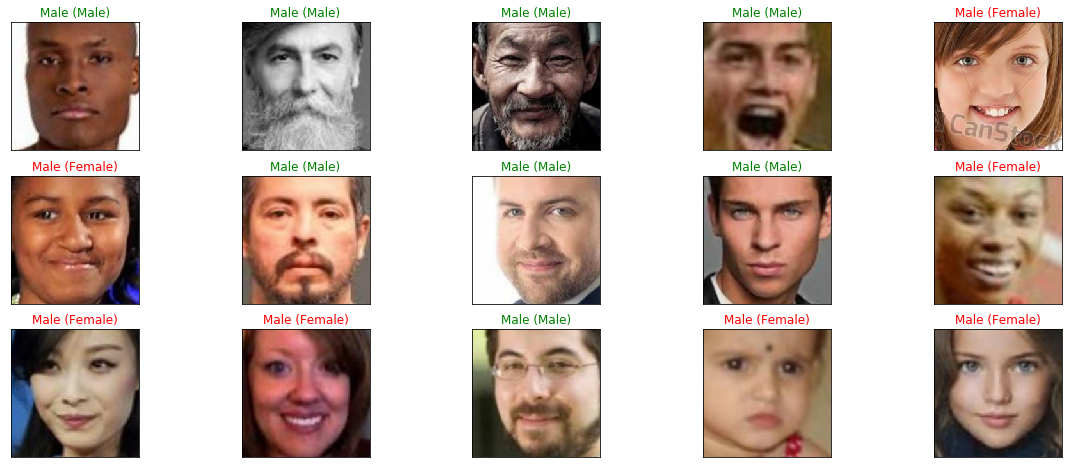

In [31]:
y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()

## Age model accuracy

In [50]:
age_model.load_weights(currentDirectory+"\INC.weights.best.age.hdf5")

# Re-evaluate the model
loss,acc = age_model.evaluate(x_test_a,  y_test_a, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Restored model, accuracy: 17.29%


In [54]:
labels_a =["CHILD", "YOUTH", "ADULT", "MIDDLEAGE", "OLD"]

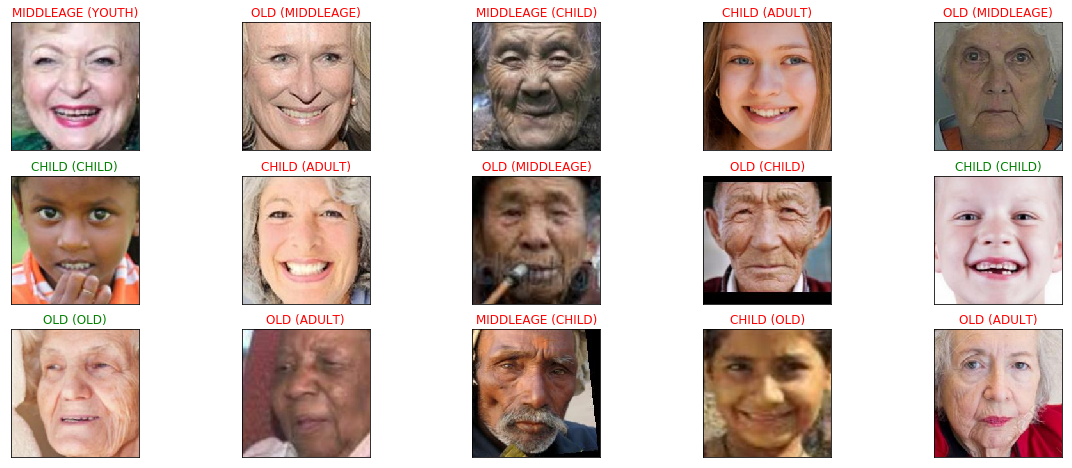

In [55]:
y_hat_a = age_model.predict(x_test_a)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test_a.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test_a[index]))
    predict_index = np.argmax(y_hat_a[index])
    true_index = np.argmax(y_test_a[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels_a[predict_index], 
                                  labels_a[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()